In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45315")
client

<Client: 'tcp://127.0.0.1:45315' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import xrft
import gsw
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
import MITgcmutils as mitutils
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Physical coefficients 
grav = 9.81
rho0 = 999.8
Cp = 3.994e3
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20

# Time set-up
years = np.arange(1967,1968,dtype=int)
dnf = 2160 #time interval
nfile = 73 #time steps in a year
ini_time = 1419120
fin_time = 1574640
ntimes = np.arange(ini_time,fin_time+dnf,dnf).reshape(len(years),nfile)

# Ensemble members 
membs = np.arange(100,148,dtype=int)

# Domain selection 
ychunk = 450
xchunk = 250
ystart = -15
yend = 50

In [4]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir_old = '/tank/topog/lsun/modewater/' # Saves cs_snap and maximum_cs
savedir = '/tank/spectre/lsun/modewater/' 
bdir = 'bcoor/'
twadir = 'TWA/'

# Geostrophy coordinates

The ensemble-mean momentum budget is closed on the z-coordinate. The plots can be used as references for the budget study on the b-coordinate. 

In [5]:
imemb = 100
year = 1967
itime = ntimes[0,0] 
ds_tmp = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' % (year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn'], 
                                     delta_t=2e2, iters=itime,
                                     chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                    )
Um_dEdx_raw = xr.DataArray(mitutils.rdmds(op.join(ddir,'ensm/run%4d/ocn/diagUm' % (year)), itrs=itime, rec=3,    # U from surface pressure
                         # usememmap=True
                                     ),
                          dims=ds_tmp.UVEL.isel(time=0).dims, coords=ds_tmp.UVEL.isel(time=0).coords
                         )   
Um_Disv_raw = xr.DataArray(mitutils.rdmds(op.join(ddir,'ensm/run%4d/ocn/diagUm' % (year)), itrs=itime, rec=5,    # Vertical dissipation
                         # usememmap=True
                                     ),
                          dims=ds_tmp.UVEL.isel(time=0).dims, coords=ds_tmp.UVEL.isel(time=0).coords
                         )   
Vm_dEdy_raw = xr.DataArray(mitutils.rdmds(op.join(ddir,'ensm/run%4d/ocn/diagVm' % (year)), itrs=itime, rec=3,    # V from surface pressure
                         # usememmap=True
                                     ),
                          dims=ds_tmp.VVEL.isel(time=0).dims, coords=ds_tmp.VVEL.isel(time=0).coords
                         )   
Vm_Disv_raw = xr.DataArray(mitutils.rdmds(op.join(ddir,'ensm/run%4d/ocn/diagVm' % (year)), itrs=itime, rec=5,    # Vertical dissipation
                         # usememmap=True
                                     ),
                          dims=ds_tmp.VVEL.isel(time=0).dims, coords=ds_tmp.VVEL.isel(time=0).coords
                         )   

Um_dEdx = Um_dEdx_raw.sel(YC=slice(ystart-12**-1,yend+2*12**-1))
Um_Disv = Um_Disv_raw.sel(YC=slice(ystart-12**-1,yend+2*12**-1))
Vm_dEdy = Vm_dEdy_raw.sel(YG=slice(ystart-12**-1,yend+2*12**-1))
Vm_Disv = Vm_Disv_raw.sel(YG=slice(ystart-12**-1,yend+2*12**-1))

ds = ds_tmp.sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                   YG=slice(ystart-12**-1,yend+2*12**-1))


dsUm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' % (year)), 
                                     grid_dir=gdir,
                                     prefix=['diagUm'], 
                                     delta_t=2e2, iters=itime,ignore_unknown_vars=True,
                                     chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                          YG=slice(ystart-12**-1,yend+2*12**-1))
dsVm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' % (year)), 
                                     grid_dir=gdir,
                                     prefix=['diagVm'], 
                                     delta_t=2e2, iters=itime,ignore_unknown_vars=True,
                                     chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                          YG=slice(ystart-12**-1,yend+2*12**-1))

res_Um = (dsUm.TOTUTEND/86400 - (dsUm.Um_Advec + dsUm.Um_dPHdx + dsUm.Um_Diss + dsUm.Um_Ext + dsUm.AB_gU + Um_dEdx + Um_Disv)).where(ds.maskW!=0.)
res_Vm = (dsVm.TOTVTEND/86400 - (dsVm.Vm_Advec + dsVm.Vm_dPHdy + dsVm.Vm_Diss + dsVm.Vm_Ext + dsVm.AB_gV + Vm_dEdy + Vm_Disv)).where(ds.maskS!=0.)


In [6]:
dsUm.Z.isel(Z=10)

<xarray.DataArray 'Z' ()>
array(-112.283485, dtype=float32)
Coordinates:
    Z        >f4 -112.3
    drF      >f4 dask.array<chunksize=(), meta=np.ndarray>
    PHrefC   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    standard_name:  depth
    long_name:      vertical coordinate of cell center
    units:          m
    positive:       down
    axis:           Z

/tank/users/lsun/.conda/envs/modewater/lib/python3.9/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 274.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tank/users/lsun/.conda/envs/modewater/lib/python3.9/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 549.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


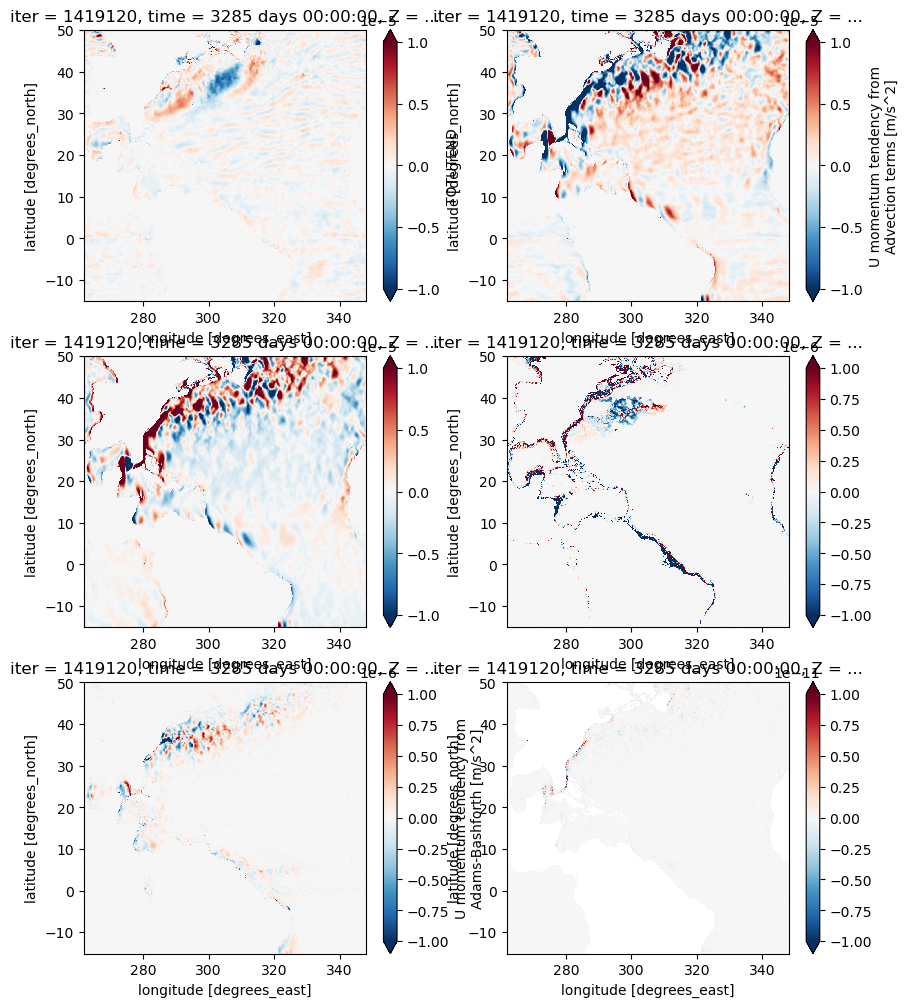

In [9]:
# Terms in the momentum equation for U
fig, axes = plt.subplots(figsize=(10,12), nrows=3, ncols=2)
(dsUm.TOTUTEND/86400).isel(Z=10).plot(ax = axes[0,0],vmax = 1e-5)
(-dsUm.Um_Advec).isel(Z=10).plot(ax = axes[0,1],vmax = 1e-5) # advection + coriolis terms
(-Um_dEdx-dsUm.Um_dPHdx).isel(Z=10).plot(ax = axes[1,0],vmax = 1e-5) # pressure gradient
(dsUm.Um_Diss + dsUm.Um_Ext + Um_Disv).isel(Z=10).plot(ax = axes[1,1],vmax = 1e-6) # external forcing 
(-dsUm.AB_gU).isel(Z=10).plot(ax = axes[2,0],vmax = 1e-6)
res_Um.isel(Z=10).plot(ax = axes[2,1],vmax = 1e-11) 



/tank/users/lsun/.conda/envs/modewater/lib/python3.9/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 274.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tank/users/lsun/.conda/envs/modewater/lib/python3.9/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 549.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


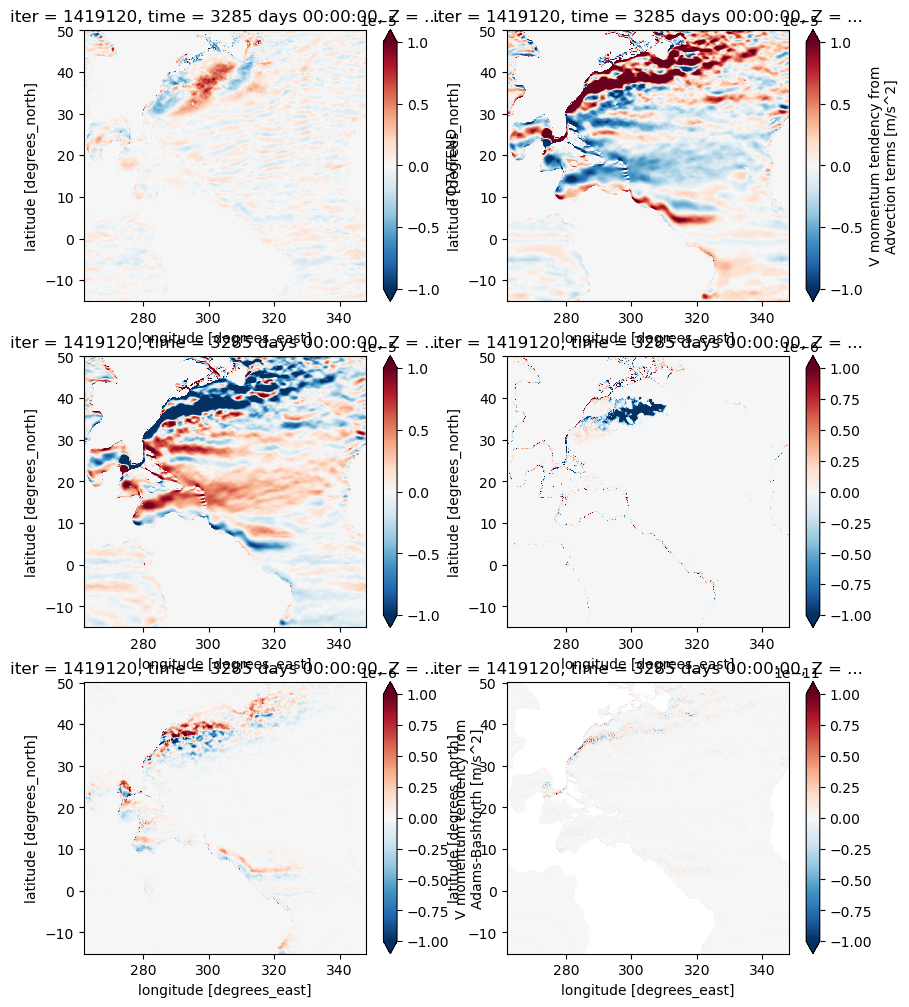

In [11]:
# Terms in the momentum equation for V
fig, axes = plt.subplots(figsize=(10,12), nrows=3, ncols=2)
(dsVm.TOTVTEND/86400).isel(Z=10).plot(ax = axes[0,0],vmax = 1e-5)
(-dsVm.Vm_Advec).isel(Z=10).plot(ax = axes[0,1],vmax = 1e-5) # advection + coriolis terms
(-Vm_dEdy-dsVm.Vm_dPHdy).isel(Z=10).plot(ax = axes[1,0],vmax = 1e-5) # pressure gradient
(dsVm.Vm_Diss + dsVm.Vm_Ext + Vm_Disv).isel(Z=10).plot(ax = axes[1,1],vmax = 1e-6) # external forcing 
(-dsVm.AB_gV).isel(Z=10).plot(ax = axes[2,0],vmax = 1e-6)
res_Vm.isel(Z=10).plot(ax = axes[2,1],vmax = 1e-11) 


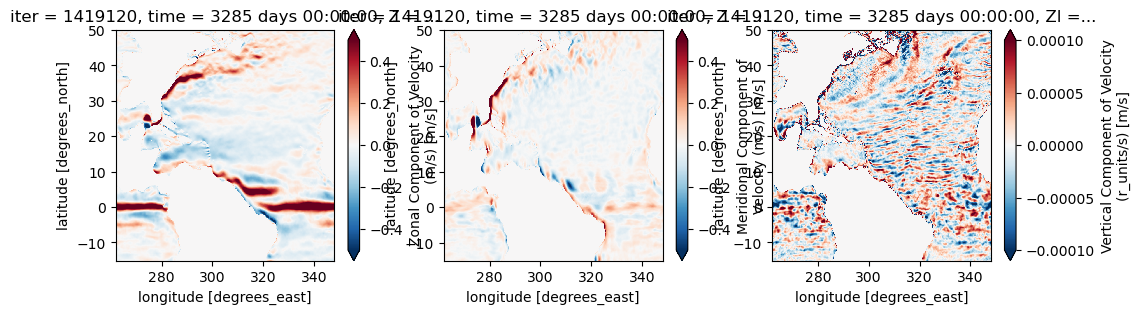

In [18]:
fig, axes = plt.subplots(figsize=(12,3), nrows=1, ncols=3)
ds.UVEL.isel(Z=10).plot(ax = axes[0],vmax = 0.5)
ds.VVEL.isel(Z=10).plot(ax = axes[1],vmax = 0.5)
ds.WVEL.isel(Zl=10).plot(ax = axes[2],vmax = 1e-4)

In [19]:
ds_tmp.close()
ds.close()
dsUm.close()
dsVm.close()

# Buoyancy coordinates

The TWA momentum budget is calculated. The terms are named the same as the notations of the corresponding variables, meaning that the signs are corrected. 
$$ \hat{u}_{\tilde{t}} + \hat{u} \hat{u}_{\tilde{x}} + \hat{v} \hat{u}_{\tilde{y}} + \hat{\varpi} \hat{u}_{\tilde{b}} - f\hat{v} + \bar{m}_{\tilde{x}} = - \bar{\mathbf{e}}_1 \cdot (\tilde{\nabla} \cdot \mathbf{E}) + \hat{\mathcal{X}}$$

$$ \hat{v}_{\tilde{t}} + \hat{u} \hat{v}_{\tilde{x}} + \hat{v} \hat{v}_{\tilde{y}} + \hat{\varpi} \hat{v}_{\tilde{b}} + f\hat{u} + \bar{m}_{\tilde{y}} = - \bar{\mathbf{e}}_2 \cdot (\tilde{\nabla} \cdot \mathbf{E}) + \hat{\mathcal{Y}}$$

In [5]:
import gsw

year = 1967
itime = ntimes[0,0]

ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,year)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], 
                             delta_t=2e2, iters=itime,
                             chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1))

fG = xr.apply_ufunc(gsw.f, ds.YG, dask='parallelized', output_dtypes=['float',])
fC = xr.apply_ufunc(gsw.f, ds.YC, dask='parallelized', output_dtypes=['float',])

dsb = xr.open_zarr(op.join(savedir,twadir,'run%4d/Dynb/%010d/' 
                                                      % (year,itime))
                  )
dsE = xr.open_zarr(op.join(savedir,twadir,'run%4d/E-P/%010d/' 
                                            % (year,itime))
                  )
dsdivE = xr.open_zarr(op.join(savedir,twadir,'run%4d/divE-P/%010d/' 
                                                   % (year,itime))
                     )

dsz = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zetab/%010d/' 
                           % (year,itime))
                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                        YG=slice(ystart-12**-1,yend+2*12**-1)
                       ).reset_coords(drop=True)

delta = .5*(dsz.delta_outer[1:].data 
            + dsz.delta_outer[:-1].data)

buoyb = -grav * delta * rho0**-1
buoybp1 = -grav * dsz.delta_outer * rho0**-1
    
dsz.coords['delta'] = ('delta',delta)

grid = Grid(dsz, periodic=['X'], 
            coords={'Z':{'center':'delta','outer':'delta_outer'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
       )


u = dsb.uhat
v = dsb.vhat
varpi = dsb.varpihat
dmdx = dsb.mbxb
dmdy = dsb.mbyb
dudt = dsb.utenhat
dvdt = dsb.vtenhat
XF = dsb.XFhat
YF = dsb.YFhat
AB_gU = dsb.AB_gUhat
AB_gV = dsb.AB_gVhat

dEdu = grid.interp(dsdivE.e00x + dsdivE.e10y + dsdivE.e20_0b + dsdivE.e20_1b,'X')
dEdv = grid.interp(dsdivE.e01x + dsdivE.e11y + dsdivE.e21_0b + dsdivE.e21_1b,'Y')

dudx = grid.diff(grid.interp(u * ds.dyG, 'X'), 'X') * ds.rAw**-1
dudy = grid.diff(grid.interp(u * ds.dxC, 'Y'), 'Y') * ds.rAw**-1
dudb = grid.interp((grid.diff(u, 'Z', boundary='extend')
                    * grid.diff(buoybp1,'Z',boundary='extend')**-1), 
                   'Z', boundary = 'extend') 

u_adv = u * dudx + grid.interp(grid.interp(v,'X'),'Y') * dudy + grid.interp(varpi, 'X') * dudb - fC * grid.interp(grid.interp(v,'X'),'Y')

dvdx = grid.diff(grid.interp(v * ds.dyC, 'X'), 'X') * ds.rAs**-1
dvdy = grid.diff(grid.interp(v * ds.dxG, 'Y'), 'Y') * ds.rAs**-1
dvdb = grid.interp((grid.diff(v, 'Z', boundary='extend')
                    * grid.diff(buoybp1,'Z',boundary='extend')**-1), 
                   'Z', boundary = 'extend') 

v_adv = grid.interp(grid.interp(u, 'Y'), 'X') * dvdx + v * dvdy + grid.interp(varpi, 'Y') * dvdb + fG * grid.interp(grid.interp(u, 'Y'), 'X') 

LHS_u = dudt + u_adv +dmdx + AB_gU
RHS_u = - dEdu + XF
res_u = LHS_u - RHS_u

LHS_v = dvdt + v_adv +dmdy + AB_gV
RHS_v = - dEdv + YF
res_v = LHS_v - RHS_v

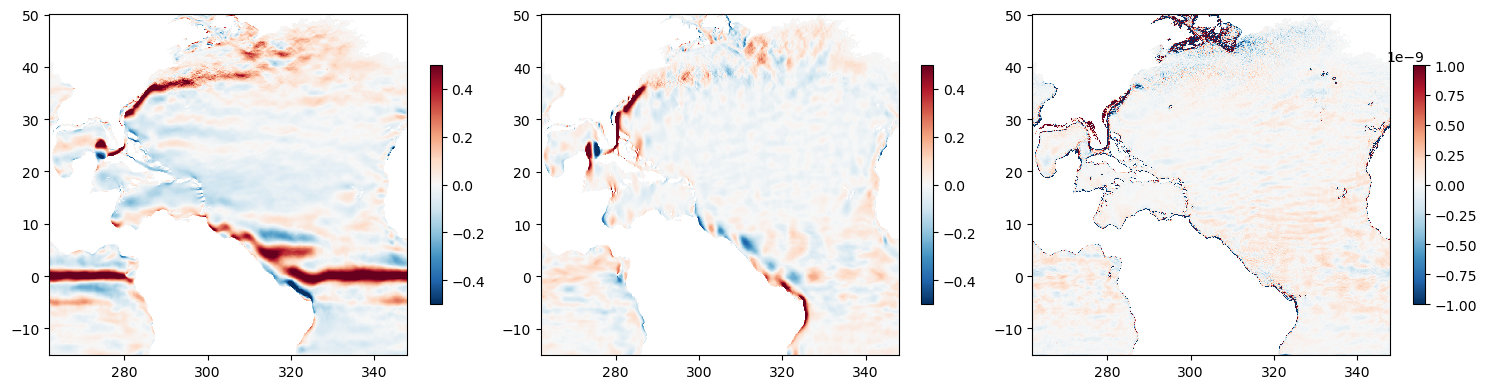

In [7]:
fig, axes = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)
fig.set_tight_layout(True)
im1 = axes[0].pcolormesh(u.XG, u.YC, 
                           u.isel(delta_outer=19), # 25.260797
                            vmin = -0.5, vmax = 0.5, cmap='RdBu_r', 
                           rasterized=True
                          )
im2 = axes[1].pcolormesh(v.XC, v.YG, 
                           v.isel(delta_outer=19), # 25.260797
                            vmin = -0.5, vmax = 0.5, cmap='RdBu_r', 
                           rasterized=True
                          )
im3 = axes[2].pcolormesh(varpi.XC, varpi.YC, 
                           varpi.isel(delta_outer=19), # 25.260797
                             vmin = -1e-9, vmax = 1e-9,cmap='RdBu_r', 
                           rasterized=True
                          )

                          
cbar1 = fig.colorbar(im1, ax=axes[0], shrink=.7)
cbar2 = fig.colorbar(im2, ax=axes[1], shrink=.7)
cbar3 = fig.colorbar(im3, ax=axes[2], shrink=.7)


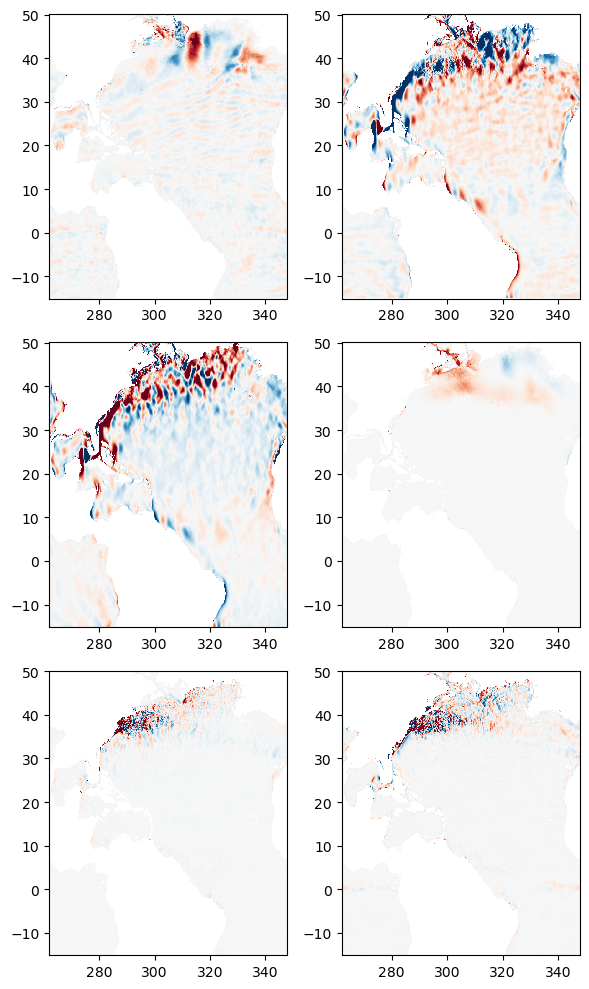

In [8]:
fig, axes = plt.subplots(figsize=(6, 10), nrows=3, ncols=2)
fig.set_tight_layout(True)
im1 = axes[0,0].pcolormesh(dudt.XG, dudt.YC, 
                           dudt.isel(delta_outer=19), # 25.260797
                            vmin = -1e-5, vmax = 1e-5, cmap='RdBu_r', 
                           rasterized=True
                          )
im2 = axes[0,1].pcolormesh(u_adv.XG, u_adv.YC, 
                         u_adv.isel(delta_outer=19), # 25.260797
                            vmin = -1e-5, vmax = 1e-5, cmap='RdBu_r', 
                           rasterized=True
                          )
im3 = axes[1,0].pcolormesh(dmdx.XG, dmdx.YC, 
                         dmdx.isel(delta_outer=19), # 25.260797
                            vmin = -1e-5, vmax = 1e-5, cmap='RdBu_r', 
                           rasterized=True
                          )
im4 = axes[1,1].pcolormesh(XF.XG, XF.YC, 
                         XF.isel(delta_outer=19), # 25.260797
                            vmin = -1e-5, vmax = 1e-5, cmap='RdBu_r', 
                           rasterized=True
                          )
im5 = axes[2,0].pcolormesh(dEdu.XG, dEdu.YC, 
                        dEdu.isel(delta_outer=19), # 25.260797
                            vmin = -1e-5, vmax = 1e-5, cmap='RdBu_r', 
                           rasterized=True
                          )
im6 = axes[2,1].pcolormesh(res_u.XG, res_u.YC, 
                          res_u.isel(delta_outer=19), # 25.260797
                            vmin = -1e-5, vmax = 1e-5, cmap='RdBu_r', 
                           rasterized=True
                          )
# cbar1 = fig.colorbar(im1, ax=axes[0], shrink=.7)
# cbar2 = fig.colorbar(im2, ax=axes[1], shrink=.7)
# cbar3 = fig.colorbar(im3, ax=axes[2], shrink=.7)


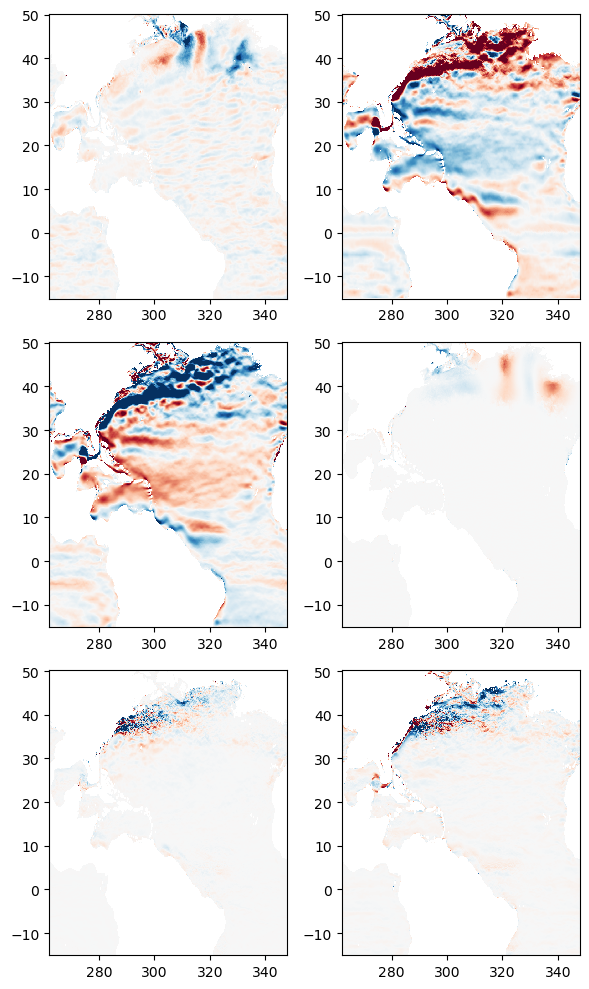

In [9]:
fig, axes = plt.subplots(figsize=(6, 10), nrows=3, ncols=2)
fig.set_tight_layout(True)
im1 = axes[0,0].pcolormesh(dvdt.XC, dvdt.YG, 
                           dvdt.isel(delta_outer=19), # 25.260797
                            vmin = -1e-5, vmax = 1e-5, cmap='RdBu_r', 
                           rasterized=True
                          )
im2 = axes[0,1].pcolormesh(v_adv.XC, v_adv.YG, 
                         v_adv.isel(delta_outer=19), # 25.260797
                            vmin = -1e-5, vmax = 1e-5, cmap='RdBu_r', 
                           rasterized=True
                          )
im3 = axes[1,0].pcolormesh(dmdy.XC, dmdy.YG, 
                         dmdy.isel(delta_outer=19), # 25.260797
                            vmin = -1e-5, vmax = 1e-5, cmap='RdBu_r', 
                           rasterized=True
                          )
im4 = axes[1,1].pcolormesh(YF.XC, YF.YG, 
                         YF.isel(delta_outer=19), # 25.260797
                            vmin = -1e-5, vmax = 1e-5, cmap='RdBu_r', 
                           rasterized=True
                          )
im5 = axes[2,0].pcolormesh(dEdv.XC, dEdv.YG, 
                        dEdv.isel(delta_outer=19), # 25.260797
                            vmin = -1e-5, vmax = 1e-5, cmap='RdBu_r', 
                           rasterized=True
                          )
im6 = axes[2,1].pcolormesh(res_v.XC, res_v.YG, 
                          res_v.isel(delta_outer=19), # 25.260797
                            vmin = -1e-5, vmax = 1e-5, cmap='RdBu_r', 
                           rasterized=True
                          )

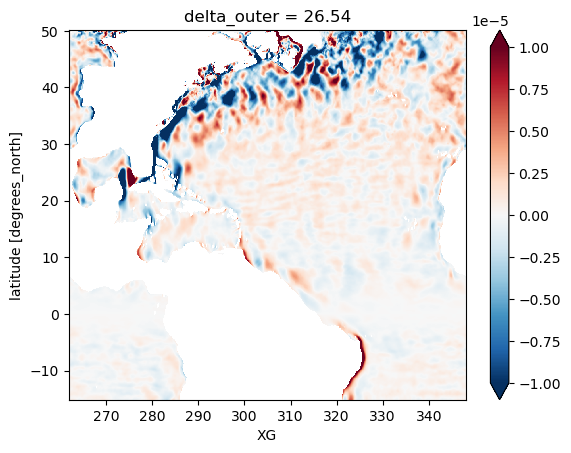

In [10]:
(-fC * grid.interp(grid.interp(v,'X'),'Y')).isel(delta_outer = 23).plot(vmax=1e-5)